<h1>Assignment 1:</h1>

The objective of this assignment is to compare the performance of decision trees and linear(logistic) regression and their effectiveness when it comes to feature selection. The dataset used is Student_Perf.csv which is derived from the original UCI version [here](https://archive.ics.uci.edu/dataset/320/student+performance)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, StratifiedKFold

<h2>Task 1: Accuracy</h2>

Load the dataset using Pandas:

In [289]:
raw = pd.read_csv("Student_Perf.csv")
raw.head()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,outcome
0,0,0.0,0.0,18,1.0,0.0,0.0,4.0,4.0,0.0,...,0.0,0.0,3.0,2.0,3.0,0.0,0.0,2.0,4.0,Low
1,1,0.0,0.0,17,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,4.0,2.0,2.0,0.0,0.0,2.0,2.0,Low
2,2,0.0,0.0,15,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,0.0,3.0,2.0,1.0,1.0,2.0,2.0,6.0,Low
3,3,0.0,0.0,15,1.0,0.0,1.0,4.0,2.0,1.0,...,1.0,1.0,2.0,1.0,1.0,0.0,0.0,4.0,0.0,High
4,4,0.0,0.0,16,1.0,0.0,1.0,3.0,3.0,1.0,...,0.0,0.0,3.0,2.0,1.0,0.0,1.0,4.0,0.0,High


We can perform a little bit of preprocessing on the data to remove the index column and split the X features from the Y classifications. At the same time, we can also shuffle the data (being sure to keep corresponding X, Y data together)

In [290]:
raw.pop(raw.columns[0])

raw = raw.sample(frac=1).reset_index(drop=True)

Yraw = raw.pop("outcome").values
Xraw = raw.values
type(Xraw),type(Yraw)

(numpy.ndarray, numpy.ndarray)

We can now normalize the above data such to avoid weighting any category higher due to the magnitude of its values. We don't have to convert the data to ordinal here as all of the X features are already all numerical.

In [291]:
scaler = MinMaxScaler().fit(Xraw)
Xraw = scaler.transform(Xraw)

Xraw

array([[0.        , 0.        , 0.14285714, ..., 0.25      , 0.75      ,
        0.08695652],
       [0.        , 1.        , 0.42857143, ..., 1.        , 1.        ,
        0.17391304],
       [1.        , 0.        , 0.28571429, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.14285714, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.14285714, ..., 0.25      , 0.5       ,
        0.        ],
       [0.        , 0.        , 0.28571429, ..., 0.        , 0.5       ,
        0.        ]])

We can now build logisitic regression and decision tree models making use of a cross validation framework to evaluate the baseline generalisation accuracy of these algorithms.

In [292]:
logistic_regression = LogisticRegression(penalty=None)
tree = DecisionTreeClassifier()

cv = StratifiedKFold(n_splits=5)

Y_pred_logistic = cross_val_predict(logistic_regression, Xraw, Yraw, cv=cv)
Y_pred_tree = cross_val_predict(tree, Xraw, Yraw, cv=cv)

#also calculate the accuracy of each model now for later anaylsis/graphing:
baseline_accuracy_logistic = sum(Y_pred_logistic[i]==Yraw[i] for i in range(len(Y_pred_logistic)))/len(Y_pred_logistic)
baseline_accuracy_tree = sum(Y_pred_tree[i]==Yraw[i] for i in range(len(Y_pred_tree)))/len(Y_pred_tree)

print("Logistic regression classification results:\n", classification_report(Yraw, Y_pred_logistic))
print("\nDecision tree classification results:\n", classification_report(Yraw, Y_pred_tree))

Logistic regression classification results:
               precision    recall  f1-score   support

        High       0.68      0.70      0.69       276
         Low       0.77      0.75      0.76       373

    accuracy                           0.73       649
   macro avg       0.73      0.73      0.73       649
weighted avg       0.73      0.73      0.73       649


Decision tree classification results:
               precision    recall  f1-score   support

        High       0.57      0.59      0.58       276
         Low       0.69      0.67      0.68       373

    accuracy                           0.64       649
   macro avg       0.63      0.63      0.63       649
weighted avg       0.64      0.64      0.64       649



The key value we are concerned with is the accuracy, as we can see, the baseline logistic regression model is more accurate than the baseline decision tree, with an accuracy of 0.73 compared to 0.64.

We can now attempt to improve the accuracy of the decision tree by performing a grid search over some of its parameters. Although the assignment specifies grid searching over only one parameter, I have found in my experience working with machine learning algorithms, that typically when you tune one parameter, the optimal values of others change as you do so. This means that it is most often more practical to tune multiple parameters, so I will grid search over three commonly used hyperparameters of decision trees, max_depth, min_samples_split and min_samples_leaf.

This code is quite complicated because we are practically unable to use the GridSearchCV method as using this would result in the models being trained on the entire dataset before being evaluated, which negates the benefits of using cross validation to evaluate our models. Because of this, I have to implement the grid search myself and use cross validation in that implementation.

In [ ]:
# define a grid of parameters to search over
param_grid = {
    'max_depth': [2, 3, 5, 10, 12, None],
    'min_samples_leaf': [1, 2, 3, 5, 10, 20],
    'min_samples_split': [2, 3, 5, 10, 15]
}

# create a dictionary for the best model which will store all necessary information for results analysis
best_model_tree = {
    'model': DecisionTreeClassifier(),
    'Y_pred': [],
    'accuracy': 0.0,
    'max_depth': 0,
    'min_samples_leaf': 0,
    'min_samples_split': 0
}

# iterate over each parameter in the grid
for max_depth_ in param_grid['max_depth']:
    for min_samples_leaf_ in param_grid['min_samples_leaf']:
        for min_samples_split_ in param_grid['min_samples_split']:
            
            # create a decision tree classifier using the parameters selected and train it with cross validation
            grid_tree = DecisionTreeClassifier(max_depth=max_depth_, min_samples_leaf=min_samples_leaf_, min_samples_split=min_samples_split_)
            Y_pred = cross_val_predict(grid_tree, Xraw, Yraw)

            # calculate the accuracy as the fraction of Y_pred which matches Yraw i.e. fraction of correct predictions
            # this uses the predictions from cross_val_predict, so essentially we are evaluating cross validation accuracy
            accuracy = sum(Y_pred[i]==Yraw[i] for i in range(len(Y_pred)))/len(Y_pred)

            # compare accuracy to the current best model, if current model is more accurate, update best model.
            if accuracy > best_model_tree['accuracy']:
                best_model_tree['accuracy'] = accuracy
                best_model_tree['Y_pred'] = Y_pred
                best_model_tree['model'] = grid_tree
                best_model_tree['max_depth'] = max_depth_
                best_model_tree['min_samples_leaf'] = min_samples_leaf_
                best_model_tree['min_samples_split'] = min_samples_split_

print("Decision tree gridsearch classification results:\n", classification_report(Yraw, best_model_tree['Y_pred']))

print("Best model parameters:\nmax_depth:", best_model_tree['max_depth'])
print("min_samples_leaf:", best_model_tree['min_samples_leaf'])
print("min_samples_split:", best_model_tree['min_samples_split'])

Decision tree gridsearch classification results:
               precision    recall  f1-score   support

        High       0.63      0.66      0.64       276
         Low       0.74      0.71      0.73       373

    accuracy                           0.69       649
   macro avg       0.68      0.69      0.69       649
weighted avg       0.69      0.69      0.69       649

Best model parameters:
max_depth: 12
min_samples_leaf: 5
min_samples_split: 15


As we can see, the values of:
<ul><li>max_depth = 12</li>
    <li>min_samples_leaf = 5</li>
    <li>min_samples_split = 15</li></ul><br>
Resulted in the best performing model with an accuracy of __ compared to __ for the baseline decision tree.

We can now perform a similar process for the logistic regression model using L1 regularization. The same problem applies here where the use of cross validation in the desired way is somewhat incompatible with GridSearchCV, so again, I will implement the grid search manually, this time searching over values of C, solver and tol.

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10, 20, 100],
    'solver': ['liblinear', 'saga'],
    'tol': [1e-4, 1e-5, 1e-6]
}

# create a dictionary for the best model which will store all necessary information for results analysis
best_model_logistic = {
    'model': LogisticRegression(penalty='l1'),
    'Y_pred': [],
    'accuracy': 0.0,
    'C': 0.0,
    'solver': '',
    'tol': 0.0
}

for C_ in param_grid['C']:
    for solver_ in param_grid['solver']:
        for tol_ in param_grid['tol']:
            
            # create a decision tree classifier using the parameters selected and train it with cross validation
            grid_logistic = LogisticRegression(penalty='l1', C=C_, solver=solver_, tol=tol_, max_iter=10000)
            Y_pred = cross_val_predict(grid_logistic, Xraw, Yraw)

            # calculate the accuracy as the fraction of Y_pred which matches Yraw i.e. fraction of correct predictions
            # this uses the predictions from cross_val_predict, so essentially we are evaluating cross validation accuracy
            accuracy = sum(Y_pred[i]==Yraw[i] for i in range(len(Y_pred)))/len(Y_pred)

            # compare accuracy to the current best model, if current model is more accurate, update best model.
            if accuracy > best_model_logistic['accuracy']:
                best_model_logistic['accuracy'] = accuracy
                best_model_logistic['Y_pred'] = Y_pred
                best_model_logistic['model'] = grid_logistic
                best_model_logistic['C'] = C_
                best_model_logistic['solver'] = solver_
                best_model_logistic['tol'] = tol_

print("Logistic Regression gridsearch classification results:\n", classification_report(Yraw, best_model_logistic['Y_pred']))

print("Best model parameters:\nC:", best_model_logistic['C'])
print("solver:", best_model_logistic['solver'])
print("tol:", best_model_logistic['tol'])

Logistic Regression gridsearch classification results:
               precision    recall  f1-score   support

        High       0.68      0.71      0.70       276
         Low       0.78      0.76      0.77       373

    accuracy                           0.74       649
   macro avg       0.73      0.73      0.73       649
weighted avg       0.74      0.74      0.74       649

Best model parameters:
C: 5
solver: saga
tol: 0.0001


As we can see, the values of:
<ul><li>C = 5</li>
    <li>solver = saga</li>
    <li>tol = 0.0001</li></ul><br>
Resulted in the best performing model with an accuracy of 0.74 compared to 0.73 for the baseline logistic regression. Interestingly, this showed only a very small or neglible improvement over the baseline logistic model over multiple runs, which will be explained later when we look at feature selection.

We can create a chart with the accuracies of both algoritms before and after regularization below.

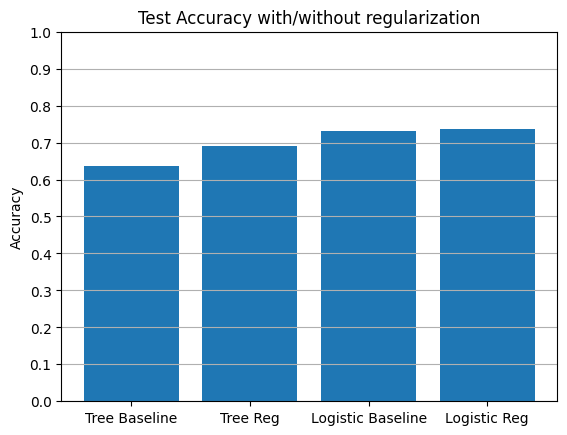

In [295]:
X = ['Tree Baseline', 'Tree Reg', 'Logistic Baseline', 'Logistic Reg']
Y = [baseline_accuracy_tree, best_model_tree['accuracy'], baseline_accuracy_logistic, best_model_logistic['accuracy']]

plt.bar(X, Y)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid('on', axis='y')
plt.title("Test Accuracy with/without regularization")
plt.ylabel("Accuracy")
plt.show()

As we can see, the decision tree model improves noticably with regularization, but we see little to no improvement from the Logistic Regression model. It makes sense for the decision tree to improve when using regularization because decision trees are inherently prone to overfitting, so they rely heavily on strong feature selection, which is what we achieve by tuning the hyperparameters of the model. The logistic model on the other hand, is more capable of handling a larger feature set, and the approximately 20 features in this dataset is relatively low in the context of machine learning, which could explain why regularization makes a minimal impact here.

<h2>Task 2: Feature Selection</h2>

We can now look at the models made above and take note of what features are/aren't selected in each, and how that may have affected overall model accuracy.

Starting with the decision tree classifier, we can begin by looking at the features used by the baseline decision tree, this will give us a point of comparison for what an 'overfit' model might look like as this is likely to use more features than is desirable to achieve the greatest accuracy.

In order to do this, we must first fit all of the models used on the full dataset, this is due to the fact that cross_val_predict() was used in all cases to evaluate the accuracy of each model using cross validation, in this case we do not particularly care about accuracy or testing, so we can fit each model on the full dataset and examine the feature selection of each.

In [ ]:
tree.fit(Xraw, Yraw)
logistic_regression.fit(Xraw, Yraw)
best_model_tree['model'].fit(Xraw, Yraw)
best_model_logistic['model'].fit(Xraw, Yraw)

Scikit-Learn includes a 'feature importance' parameter in its Decision tree classifier which lets us view how much the model is valuing certain features as shown below

Text(0.5, 1.0, 'Baseline Decision tree feature importance')

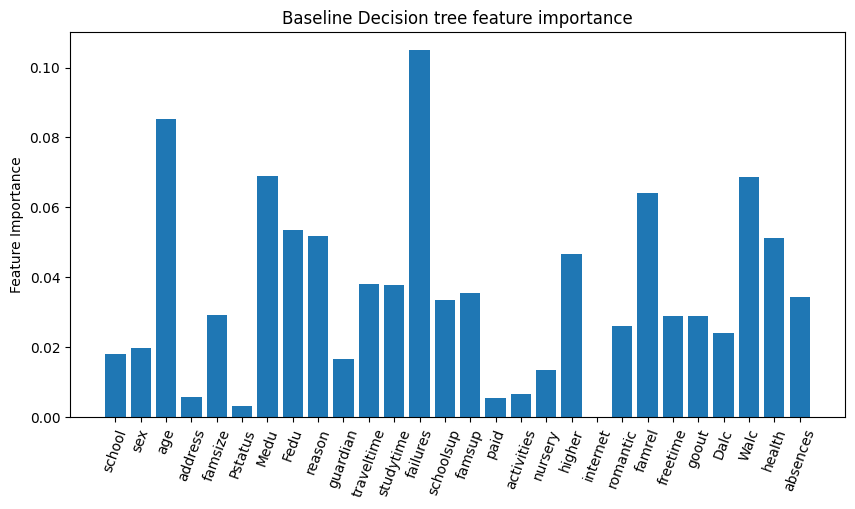

In [297]:
importances = tree.feature_importances_
X = []
Y_tree_baseline = []

for i, importance in enumerate(importances):
    X.append(raw.columns[i])
    Y_tree_baseline.append(importance)

plt.figure(figsize=(10, 5))
plt.bar(X, Y_tree_baseline)
plt.tick_params(axis='x', labelrotation=70)
plt.ylabel("Feature Importance")
plt.title("Baseline Decision tree feature importance")

We can then perform the same analysis on the decision tree with regularization and compare the results.

Text(0.5, 1.0, 'Regularized Decision tree feature importance')

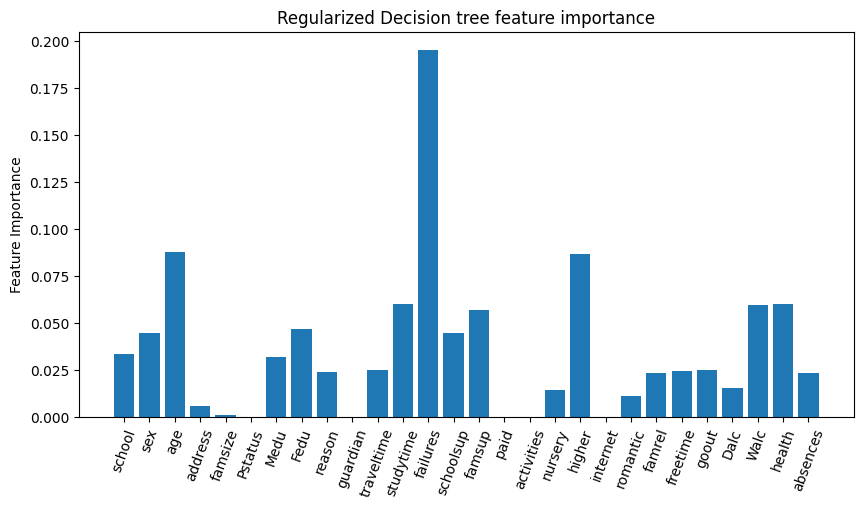

In [298]:
importances = best_model_tree['model'].feature_importances_
X = []
Y_tree_reg = []

for i, importance in enumerate(importances):
    X.append(raw.columns[i])
    Y_tree_reg.append(importance)

plt.figure(figsize=(10, 5))
plt.bar(X, Y_tree_reg)
plt.tick_params(axis='x', labelrotation=70)
plt.ylabel("Feature Importance")
plt.title("Regularized Decision tree feature importance")

As we can visually see, the regularized decision tree uses much stricter feature selection, with many features left out entirely and the 'failures' feature standing out as being the most valued feature, and having nearly double the feature importance compared to in the baseline model. The scales of both of these charts are different, so we can quantify this by finding the median feature importance of each model, as a rough measure of model complexity.

In [299]:
baseline_tree_median = np.median(Y_tree_baseline)
reg_tree_median = np.median(Y_tree_reg)

print("Baseline decision tree median feature importance:", round(baseline_tree_median, 4))
print("Regularized decision tree median feature importance:", round(reg_tree_median, 4))

Baseline decision tree median feature importance: 0.0314
Regularized decision tree median feature importance: 0.0248


As we can see by the fact that the median feature importance of the regularized tree is lower than the baseline, despite the importance of the most important feature nearly doubling, the regularized tree is more 'focused' on certain features which yield the best results, and seems to overfit less than the baseline tree, hence its higher cross validation accuracy.

As for variance across multiple runs, I ran this multiple times and from the graphs, it appears that the baseline decision tree's feature selection remains essentially constant, although there is major variance in the selections of the regularized tree. Particularly the 'age' features seems to go from having a relatively high importance to being completely disregarded over multiple runs, although 'failures' and 'higher' are generally the two most important features. This variance is likely due to the fact that cross validation accuracy is the metric being used to evaluate the grid searches. This means that on different runs, the data will be shuffled differently and different folds will be seen, resulting in different hyperparameter choices, which in turn have a major affect on feature selection.

<br> We can now continue onto the logistic regression models and evaluate their feature selection.

Text(0.5, 1.0, 'Baseline Logistic regression feature importance')

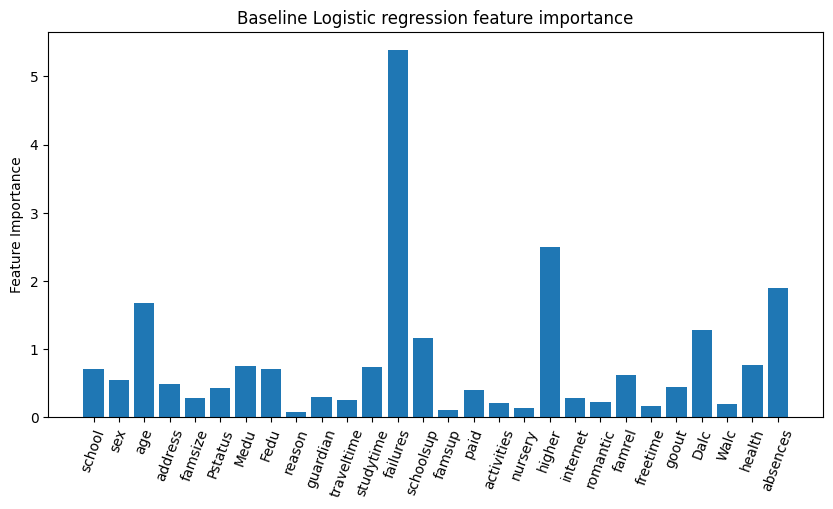

In [300]:
X = []
Y_log_baseline = []

for i, importance in enumerate(logistic_regression.coef_[0]):
    X.append(raw.columns[i])
    Y_log_baseline.append(np.abs(importance))

plt.figure(figsize=(10, 5))
plt.bar(X, Y_log_baseline)
plt.tick_params(axis='x', labelrotation=70)
plt.ylabel("Feature Importance")
plt.title("Baseline Logistic regression feature importance")

As we can see, although numerically, we cannot compare these to the decision tree, we can see proportionally, that the logistic regression places high importance on similar features to the regularized decision tree, with 'failures' and 'higher' being the two most important features, and everything else having relatively low weights.

Moving on to the regularized logistic regression:

Text(0.5, 1.0, 'Regularized Logistic regression feature importance')

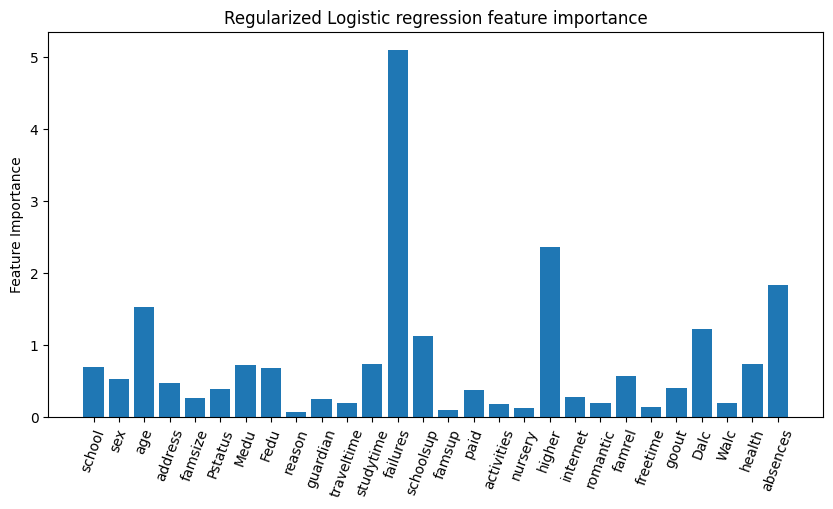

In [301]:
X = []
Y_log_reg = []

for i, importance in enumerate(best_model_logistic['model'].coef_[0]):
    X.append(raw.columns[i])
    Y_log_reg.append(np.abs(importance))

plt.figure(figsize=(10, 5))
plt.bar(X, Y_log_reg)
plt.tick_params(axis='x', labelrotation=70)
plt.ylabel("Feature Importance")
plt.title("Regularized Logistic regression feature importance")

We can see here that regularization does nearly nothing to change the feature selection of the Logistic regression model. The two graphs are so similar in fact that I thought it was a bug in my code, but upon looking at both side by side, there are some tiny differences, the regularized model appears to put slightly less importance on 'failures'. There really is no point in perfoming the median calculation as in the decision trees here, because the graphs are nearly identical and its clear that the models use very similar feature selection.

The fact that the difference in feature selection and weighting between these two models is very small almost certainly explains the neglible accuracy improvement seen between the two of them. This essentially demonstrates that the baseline logistic regression model is already very good at feature selection and dealing with overfitting, atleast on datasets with a low number of features like this one.

Comparing the Decision Tree and Logistic Regression then, it is clear that the baseline decision tree is highly prone to overfitting and we can see this in its 'shotgun approach' to feature selection, with nearly every feature included at a relatively high importance. All three other models however seem to be much more particular about feature selection, with the Logistic regression models agreeing with the regularized decision tree model on the 'failures' and 'higher' features. The models differ slightly in that the Logistic regression seems to weight 'absences' much higher than the decision tree, and the decision tree sometimes weighs 'age' highly, unlike the logistic models.

The failure of the baseline decision tree model to select the most impactful features in this dataset with a relatively low dimensionality indicates that this type of model may be more suited to lower dimensionality datasets closer to 5-10 features, whereas the minimal impact we saw on the logistic model after regularization would indicate that this model may be best suited to much higher dimensionality datasets in the hundreds or thousands of features, in which case regularization may have a much larger impact.